In [1]:
import bls_cpu as gbls
import utils_python.transitplot as transitp
import utils_python.transitfit as transitf
import utils_python.transitmodel as transitm
import transitPy5 as tpy5
import numpy as np

In [2]:
# Get the data file
tic = 55849732
datadir = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1toiv2/tlc" + str(tic) + "/"
datafile = "tlc" + str(tic) + ".dat"

# Read it
phot = tpy5.readphot(datadir + datafile)

freqs:  0.005602245211813537 2.0
nstep:  148690


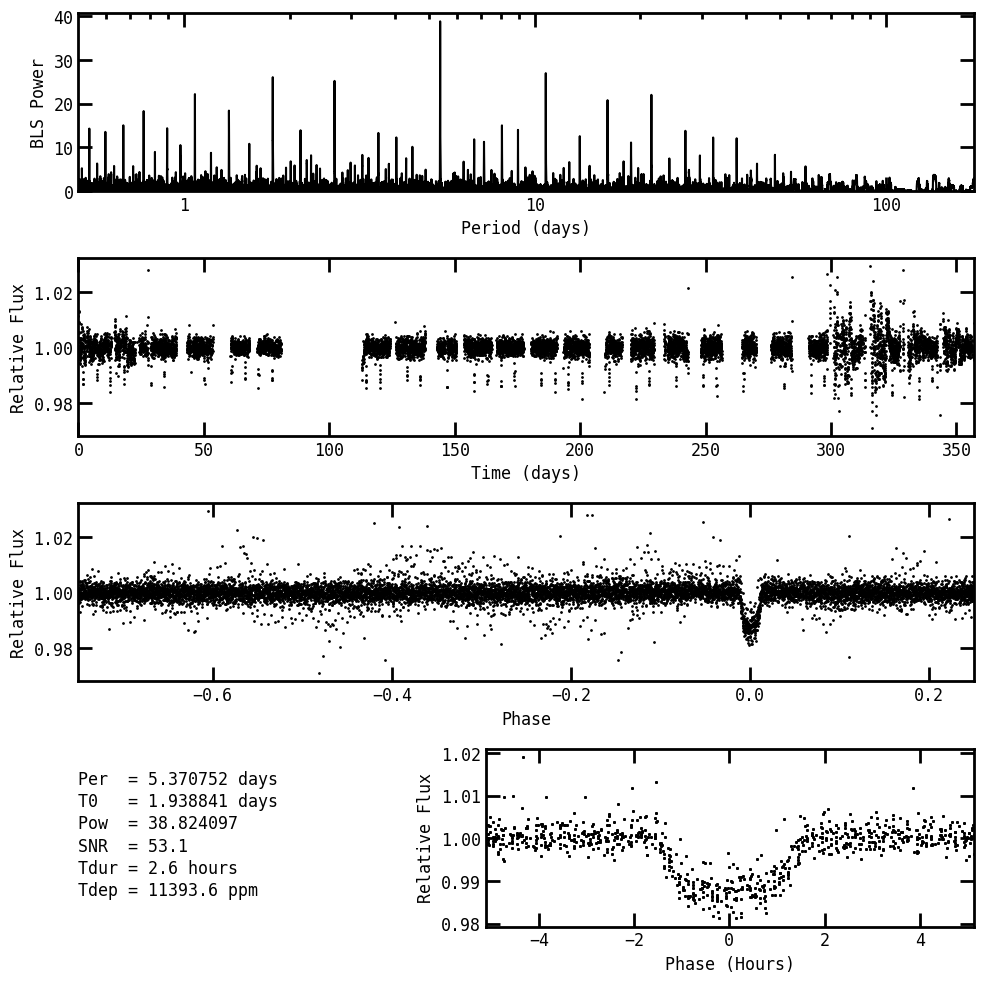

In [3]:
# Run BLS to find a transit
gbls_inputs = gbls.gbls_inputs_class()
gbls_inputs.zerotime = min(phot.time)
gbls_inputs.lcdir    = datadir
gbls_inputs.filename = datafile
gbls_ans = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

In [10]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = 0.6    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.nl3 = 0.6    # q1 (limb-darkening)
sol.nl4 = 0.4    # q2 (limb-darkening)
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)

# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

In [11]:
# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot.time - gbls_inputs.zerotime, phot.flux+1, phot.ferr, phot.itime)

ρ (g/cm³):                      2.1923690 ± 20.5610352
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                   0.6 ± 0.0
q2:                                   0.4 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         1.0000889 ± 0.0021007
t0 (days):                      1.9365442 ± 0.1098221
Period (days):                  5.3708308 ± 0.0032168
Impact parameter:               4.679e-06 ± 6.664e+05
Rp/R*:                          0.0999127 ± 0.1245829
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


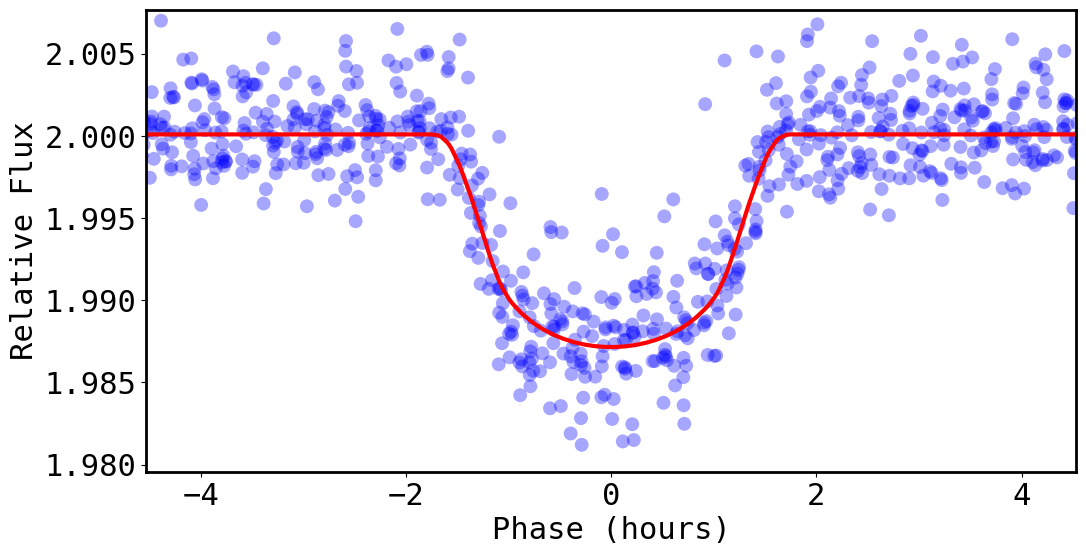

In [12]:
# Plotting
transitp.printParams(sol_fit)
transitp.plotTransit(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol_fit, phot.itime)